In [ ]:
import os
import json
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from datascience import *

In [ ]:
timestamps_dir = r"/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps"
timestamps = [os.path.join(timestamps_dir, ts) for ts in os.listdir(timestamps_dir)]
timestamps[1]

In [89]:
# if a value has a high difference from the moving average, replace it with neighboring value

def get_time_remaining_from_timestamps(fp):

    with open(fp, 'r') as f:
        data = json.load(f)
    time_remaining = []
    for k, v in data.items():
        tr = v['time_remaining']
        time_remaining.append(tr) if tr != None else time_remaining.append(0)
    return time_remaining

def denoise_time_remaining(time_remaining):

    def moving_average(x, window):
        return np.convolve(x, np.ones(window), 'same') / window

    def normalize(arr):
        _min = arr.min()
        _max = arr.max()
        return (arr - _min) / (_max - _min)

    def update_time_remaining(remove_indices, time_remaining):
        for idx, remove in enumerate(remove_indices):
            if remove:
                # Find nearest neighbor with remove == 0
                left_idx = idx - 1
                right_idx = idx + 1
                while left_idx >= 0 and remove_indices[left_idx]:
                    left_idx -= 1
                while right_idx < len(remove_indices) and remove_indices[right_idx]:
                    right_idx += 1
                # Choose the closest valid neighbor
                if left_idx >= 0 and (right_idx >= len(remove_indices) or (idx - left_idx) <= (right_idx - idx)):
                    time_remaining[idx] = time_remaining[left_idx]
                elif right_idx < len(remove_indices):
                    time_remaining[idx] = time_remaining[right_idx]

    time_remaining = np.array(time_remaining.copy())
    time_remaining_og = time_remaining.copy()

    expected = np.arange(0, 720, 720 / len(time_remaining))[::-1]
    diff_expected = abs(expected - time_remaining_og)
    norm_expected_diff = normalize(diff_expected)
    remove_indices = (norm_expected_diff > 0.5).astype(int)

    update_time_remaining(remove_indices, time_remaining)

    mvg_avg = moving_average(time_remaining, 1000)
    diff = abs(time_remaining - mvg_avg)
    norm_diff = normalize(diff)
    remove_indices = (norm_diff > 0.05).astype(int)

    update_time_remaining(remove_indices, time_remaining)

    return time_remaining

In [90]:
def interpolate(time_remaining):

    time_remaining = time_remaining.copy()
    fps = 30
    multiplier = 0
    decreasing = False

    for i in range(len(time_remaining) - 1):
        current, next_value = time_remaining[i], time_remaining[i + 1]
        peak_value = time_remaining[min(i + fps, len(time_remaining) - 1)]

        if current == 0:
            continue

        decreasing = peak_value < current
        if decreasing:
            if multiplier > 30:
                multiplier, decreasing = 0, False
                continue

            time_remaining[i] -= round((1/30) * multiplier, 2)
            multiplier = 0 if next_value < current else multiplier + 1
        # else:
        #     time_remaining[i] = 0

    return time_remaining

In [ ]:
fp = 'processed_vids.txt'
dir_p = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamp-visualizations'
with open(fp, 'w') as f:
    vids = os.listdir(dir_p)
    for v in vids:
        f.write(v)
        f.write('\n')

In [115]:
i = 9
time_remaining = get_time_remaining_from_timestamps(timestamps[i])
denoised_time_remaining = denoise_time_remaining(time_remaining)
interpolated_time_remaining = interpolate(denoised_time_remaining)
indicies = np.arange(0, len(time_remaining), 1)

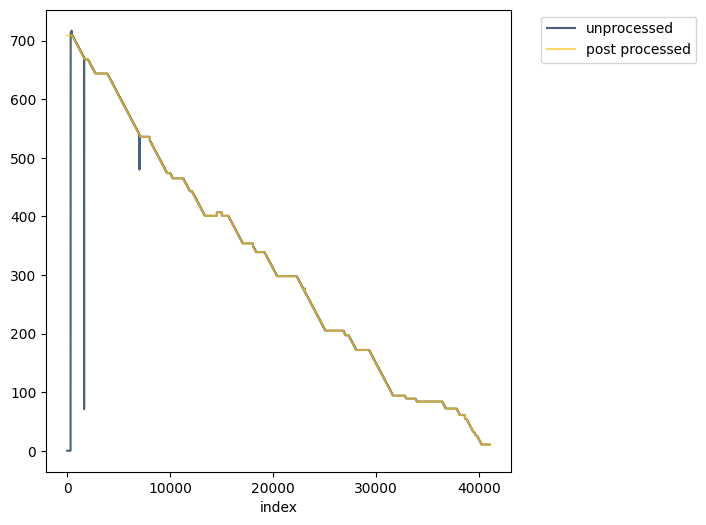

In [116]:
Table().with_columns(
    'index', indicies,
    'unprocessed', time_remaining,
    'post processed', interpolated_time_remaining
).plot('index')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(indicies, time_remaining, label='Unprocessed', marker='o')
plt.plot(indicies, interpolated_time_remaining, label='Post Processed', marker='x')
plt.xlabel('Index')
plt.ylabel('Time Remaining')
plt.title('Comparison of Unprocessed and Post Processed Data')
plt.legend()
plt.grid(True)
plt.show()